In [ ]:
# !pip install ultralytics easyocr opencv-python matplotlib

In [ ]:
!unzip /content/License-Characters-by-2-27classes.zip -d /content/Dataset/

In [ ]:
a2eL = {
    'ا': 'A',
    'ب': 'B',
    'ج': 'J',
    'د': 'D',
    'ر': 'R',
    'س': 'S',
    'ص': 'S',
    'ط': 'T',
    'ع': 'T',
    'ق': 'G',
    'ك': 'K',
    'ل': 'L',
    'م': 'Z',
    'ن': 'N',
    'ه': 'H',
    'و': 'O',
    'ي': 'E'
}

e2aL = {
     'A':'ا',
     'B':'ب',
     'J':'ج',
     'D':'د',
     'R':'ر',
     'S':'س',
     'S':'ص',
     'T':'ط',
     'T':'ع',
     'G':'ق',
     'K':'ك',
     'L':'ل',
     'Z':'م',
     'N':'ن',
     'H':'ه',
     'O':'و',
     'E':'ي',
}

a2eN = {
    '٠': '0',
    '١': '1',
    '٢': '2',
    '٣': '3',
    '٤': '4',
    '٥': '5',
    '٦': '6',
    '٧': '7',
    '٨': '8',
    '٩': '9'
}

e2aN = {
    '0':'٠',
    '1':'١',
    '2':'٢',
    '3':'٣',
    '4':'٤',
    '5':'٥',
    '6':'٦',
    '7':'٧',
    '8':'٨',
    '9':'٩',
}

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoProcessor
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import easyocr
import os
from PIL import Image


# processer = AutoProcessor.from_pretrained('stepfun-ai/GOT-OCR2_0', trust_remote_code=True)

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


image_path = '/content/8.jpg'
image = Image.open(image_path).convert("RGB")

pixel_values = processor(images=image, return_tensors="pt").pixel_values

model_path = 'yolo_model.pt'

arabic_characters = set("٠١٢٣٤٥٦٧٨٩")
english_characters = set("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")

def translate_text(text):
    if text in a2eL:
        return a2eL[text]
    elif text in a2eN:
        return a2eN[text]

    return text

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

generated_text

'2549 to'


0: 416x640 1 09, 64.9ms
Speed: 1.7ms preprocess, 64.9ms inference, 6.9ms postprocess per image at shape (1, 3, 416, 640)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


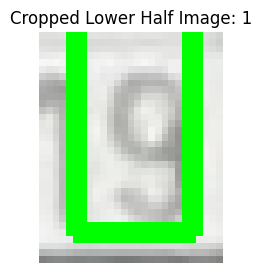

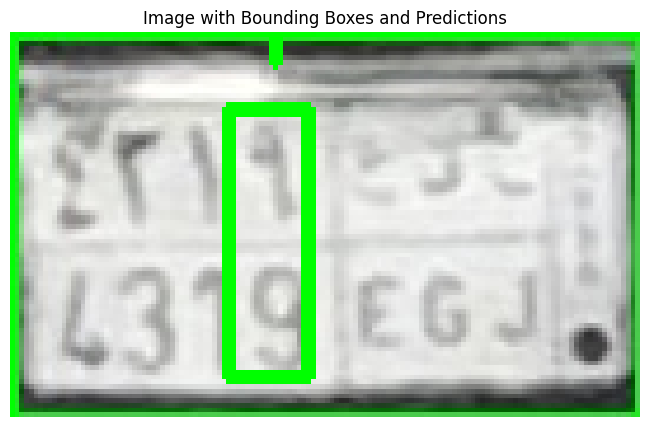

License Plate Prediction: 1


In [ ]:
def add_padding(cropped_img, padding=10):
    h, w, _ = cropped_img.shape
    padded_img = cv2.copyMakeBorder(cropped_img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return padded_img

# Function to filter and clean the predicted text, ensuring it only contains a valid character
def filter_text(text):
    # Filter Arabic characters
    arabic_text = ''.join([char for char in text if char in arabic_characters])

    # Filter English characters
    english_text = ''.join([char for char in text if char in english_characters])

    # If both are found, prioritize the selection (modify as per your preference)
    if arabic_text:
        return arabic_text[0]  # Return the first Arabic character
    elif english_text:
        return english_text[0]  # Return the first English character

    # If no valid character is found, return an empty string
    return ""

# Function to perform OCR on the lower half of each bounding box and return a single character (Arabic or English)
def ocr_on_bounding_box(image, bbox, idx, margin=5):
    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = map(int, bbox[:4])

    # Increase the bounding box size by the margin, making sure not to exceed the image boundaries
    x_min = max(0, x_min - margin)
    y_min = max(0, y_min - margin)
    x_max = min(image.shape[1], x_max + margin)
    y_max = min(image.shape[0], y_max + margin)

    # Compute the middle point of the bounding box height
    middle_y = (y_min + y_max) // 2

    # Crop only the lower half of the bounding box
    lower_half_img = image[middle_y:y_max, x_min:x_max]

    # Add padding to the cropped image if needed
    padded_img = add_padding(lower_half_img)

    # Save the padded cropped image temporarily
    cropped_img_path = f"cropped_{idx}.jpg"
    cv2.imwrite(cropped_img_path, padded_img)

    # Perform OCR detection using the transformer model
    res = model.chat(tokenizer, cropped_img_path, ocr_type='ocr')

    # Remove the temporary cropped image
    os.remove(cropped_img_path)

    # Filter the result to ensure it only contains one valid character (either Arabic or English)
    best_text = filter_text(res)

    return best_text, lower_half_img

# Function to use YOLO for bounding box detection, crop images, and apply the transformer OCR model
def detect_and_ocr(image_path, model_path):
    # Load the YOLO model
    yolo_model = YOLO(model_path)

    # Load the image
    image = cv2.imread(image_path)

    # Perform YOLO prediction on the image
    results = yolo_model.predict(source=image, conf=0.01)

    # Extract bounding boxes from YOLO predictions (results[0].boxes.data gives you the bbox data)
    bounding_boxes = results[0].boxes.data.cpu().numpy()  # Convert tensor to numpy array

    # Sort bounding boxes from left to right based on the x_min value (the leftmost point)
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])  # Sort by x_min (x[0])

    # Initialize an empty string to store the final license plate prediction
    license_plate_prediction = ''

    # Loop through each bounding box (sorted) and apply OCR
    for idx, bbox in enumerate(bounding_boxes):
        # Perform OCR on the lower half of the cropped image from the bounding box, with expanded margin
        predicted_text, cropped_img = ocr_on_bounding_box(image, bbox, idx, margin=5)  # Margin is 5 pixels

        # Add the predicted text to the final license plate prediction
        license_plate_prediction += predicted_text

        # Draw bounding box on the original image
        x_min, y_min, x_max, y_max = map(int, bbox[:4])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, predicted_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Show each cropped image separately
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Cropped Lower Half Image: {predicted_text}')
        plt.axis('off')
        plt.show()

    # Show the original image with bounding boxes
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image with Bounding Boxes and Predictions")
    plt.axis('off')
    plt.show()

    # Return the final license plate prediction
    return license_plate_prediction




# Run the detection and OCR pipeline
license_plate_prediction = detect_and_ocr(image_path, model_path)

# Print the final license plate prediction
print("License Plate Prediction:", license_plate_prediction)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import easyocr

model_path = 'yolo_model.pt'
model = YOLO(model_path)

image_path = '/content/Dataset/License-Characters-by-2-27classes/train/ckictw05s0001246aeel6cew4.jpeg'
image = cv2.imread(image_path)

H, W = image.shape[:2]

results = model.predict(image, conf=0.01)


0: 352x640 2 02s, 1 03, 1 05, 1 11, 1 12, 1 18, 37.2ms
Speed: 1.4ms preprocess, 37.2ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


In [ ]:
# Get the bounding boxes (results[0].boxes.data gives you the bbox data)
bounding_boxes = results[0].boxes.data.cpu().numpy()

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])  # You can add other languages if needed

# Function to perform OCR on each bounding box
def ocr_on_bounding_box(image, bbox):
    x_min, y_min, x_max, y_max, confidence, _ = bbox

    # Convert float values to integers for cropping the image
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Crop the image based on the bounding box
    cropped_img = image[y_min:y_max, x_min:x_max]

    # Use EasyOCR to detect text in the cropped region
    ocr_results = reader.readtext(cropped_img)

    # Get the best result based on confidence
    if ocr_results:
        highest_confidence = max(ocr_results, key=lambda res: res[2])
        text, confidence = highest_confidence[1], highest_confidence[2]
        return text, confidence
    else:
        return '', 0


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

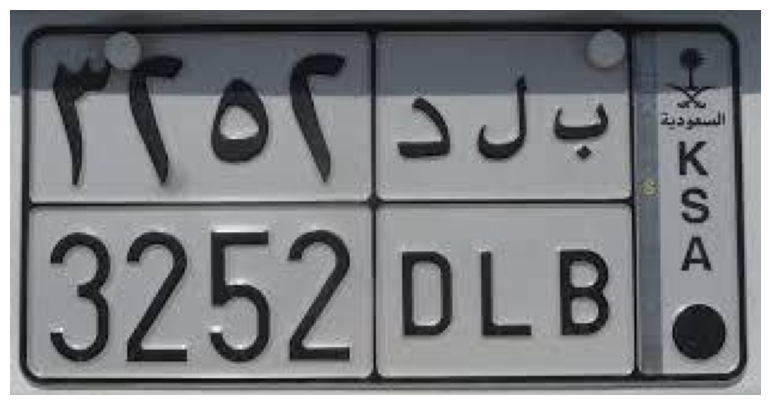

License Plate Prediction: B35


In [ ]:
# Initialize an empty string to store the final license plate prediction
license_plate_prediction = ''

# Draw bounding boxes and perform OCR for each box
for bbox in bounding_boxes:
    x_min, y_min, x_max, y_max, confidence, class_id = bbox.astype(int)

    # Perform OCR on each bounding box
    character, char_confidence = ocr_on_bounding_box(image, bbox)

    # Add the character to the final license plate prediction
    if char_confidence > 0:  # Adjust confidence threshold as needed
        license_plate_prediction += character

    # Draw the bounding box on the image (for visualization)
    # cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # cv2.putText(image, character, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the final license plate prediction
print("License Plate Prediction:", license_plate_prediction)

In [ ]:
!pip install tiktoken verovio

# !pip install verovio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 50.6 MB/s eta 0:00:00


In [ ]:
!pip install paddlepaddle paddleocr paddlepaddle-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 826.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=5c1f8815c3cf1e257fdb4ef574e842ef61abd21adad076c891380ba3fd1cc193
  Stored in 

[2024/09/30 14:33:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

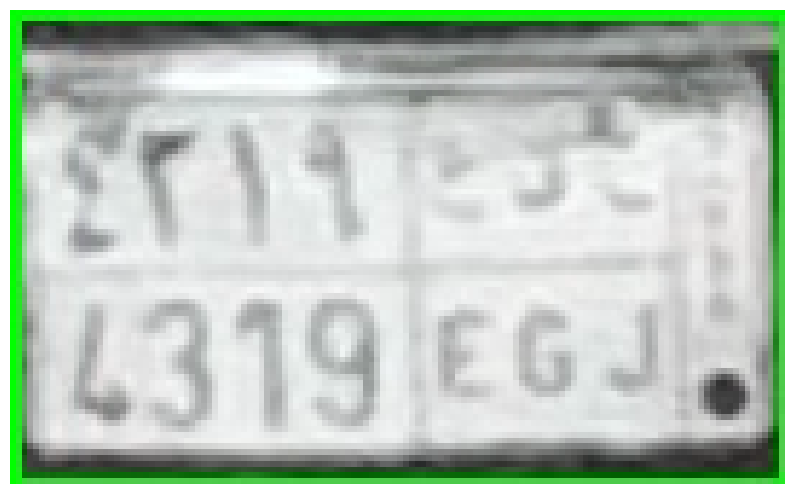

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import matplotlib.pyplot as plt

# Initialize the PaddleOCR model (Enable the correct language model: Arabic or English)
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Use 'en' for English and 'ar' for Arabic

# Path to the license plate image
image_path = '/content/8.jpg'

# Read the image using OpenCV
image = cv2.imread(image_path)

# Perform OCR detection on the image
ocr_results = ocr.ocr(image_path)

# Extract the OCR results (bounding boxes and recognized text)
for line in ocr_results:
    for text_info in line:
        text = text_info[1][0]  # The recognized text
        confidence = text_info[1][1]  # Confidence score
        print(f"Detected text: {text} (Confidence: {confidence})")

# Visualize the results by drawing bounding boxes and recognized text on the image
# Convert the OpenCV image to RGB (for visualization)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract the boxes and texts from the results
boxes = [item[0] for item in ocr_results[0]]
texts = [item[1][0] for item in ocr_results[0]]
scores = [item[1][1] for item in ocr_results[0]]

# Draw the results on the image
# image_with_boxes = draw_ocr(image_rgb, boxes, texts, scores, font_path='path_to_font')  # Optional: provide a font path if needed

# Convert back to OpenCV format for visualization with matplotlib
image_with_boxes = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.show()


In [ ]:
import random
import string
import math
import itertools
import os

import numpy as np
import pandas as pd
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import imgaug.augmenters as iaa

from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models

import xml.etree.ElementTree as ET

import cv2

In [ ]:
# Define the directory where the XML files and images are stored
xml_dir = '/content/Dataset/License-Characters-by-2-27classes/train'  # Update with the correct path
image_dir = '/content/Dataset/License-Characters-by-2-27classes/train'  # Update with the correct path

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text

    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

    return filename, labels

def has_three_alphabets(labels):
    alphabet_count = sum([1 for label in labels if label.isalpha()])
    return alphabet_count == 3

image_labels = []
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_dir, xml_filename)

        image_filename, labels = parse_xml(xml_file_path)

        if has_three_alphabets(labels):
            image_path = os.path.join(image_dir, image_filename)
            image_labels.append((image_path, labels))

In [ ]:
image_paths = []
labels = []

for path,label in image_labels:
  image_paths.append(path)
  labels.append(label)

In [ ]:
labels_test = [''.join(i) for i in labels]

In [ ]:
labels = labels_test

SyntaxError: invalid syntax (<ipython-input-100-f80a7ebc0a67>, line 1)

In [ ]:
from paddleocr import PaddleOCR
from sklearn.metrics import accuracy_score

# Initialize PaddleOCR (for English or Arabic as needed)
ocr = PaddleOCR(use_angle_cls=True, lang='en', ocr_version='PP-OCRv4', use_space_char=True)

def get_ocr_result(image_path):
    # Perform OCR on the image
    ocr_results = ocr.ocr(image_path,det=True,cls=False,rec=True)

    # If the result is None or empty, return an empty string
    if ocr_results is None or len(ocr_results) == 0:
        return ""

    # Collect all texts and confidence scores from OCR
    most_confident_text = ""
    highest_confidence = 0

    # Iterate through the results (Ensure it is iterable)
    for line in ocr_results:
        if line is not None:  # Check if the line itself is not None
            for text_info in line:
                if text_info and isinstance(text_info, list) and len(text_info) > 1:
                    text = text_info[1][0]  # Extract recognized text
                    confidence = text_info[1][1]  # Extract confidence score
                    # Keep the most confident text
                    if confidence > highest_confidence:
                        highest_confidence = confidence
                        most_confident_text = text

    return most_confident_text

# Function to compute accuracy between OCR results and ground truth labels
def evaluate_ocr(image_paths, labels):
    predicted_texts = []
    for image_path in image_paths:
        # Get the most confident text for each image
        ocr_text = get_ocr_result(image_path)
        predicted_texts.append(ocr_text)

    # Calculate the accuracy score between the predicted texts and ground truth labels
    accuracies = [1 if predicted == label else 0 for predicted, label in zip(predicted_texts, labels)]
    overall_accuracy = sum(accuracies) / len(accuracies)

    # Optionally, return more detailed comparison results
    return overall_accuracy, predicted_texts

# Example usage:


# Run evaluation
overall_accuracy, predicted_texts = evaluate_ocr(image_paths, labels)

# Output the results
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
for i, (image, prediction, label) in enumerate(zip(image_paths, predicted_texts, labels)):
    print(f"Image {i+1}: {image}")
    print(f"Predicted: {prediction}, Ground Truth: {label}")


[2024/09/30 15:38:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
image_path = '/content/8.jpg'
ocr_results = ocr.ocr(image_path,det=True,cls=False,rec=True)


[2024/09/30 15:30:21] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.03303122520446777
[2024/09/30 15:30:21] ppocr DEBUG: rec_res num  : 2, elapsed : 0.11526274681091309


In [ ]:
# ocr_results

[[('A9E!', 0.2918105125427246)]]

In [ ]:
# labels[0], predicted_texts[1]

('7090HHJ', '')

In [ ]:
# !wget https://paddleocr.bj.bcebos.com/rec/ch/ch_PP-OCRv3_rec_train.tar
# !tar -xvf ch_PP-OCRv3_rec_train.tar


tar: ch_PP-OCRv3_rec_train.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
